In [1]:
# pandas
import pandas as pd
from pandas import Series,DataFrame

# numpy, matplotlib, seaborn
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_style('whitegrid')
%matplotlib inline

In [2]:
import sys, os
MY_CODE_PATH = os.path.join(os.path.dirname(sys.path[0]), '../../useful_code')
sys.path.append(MY_CODE_PATH)

In [77]:
import scipy.stats as stats
from sklearn.pipeline import Pipeline, make_pipeline
from sklearn.preprocessing import StandardScaler, Imputer, PolynomialFeatures
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.model_selection import cross_val_score, GridSearchCV, KFold, RandomizedSearchCV

from sklearn.ensemble import AdaBoostRegressor, GradientBoostingRegressor, \
    RandomForestRegressor, BaggingRegressor, ExtraTreesRegressor
from sklearn.tree import DecisionTreeRegressor

from sklearn.metrics import mean_squared_error, make_scorer
from sklearn.linear_model import LassoCV, RidgeCV, Lasso, Ridge, ElasticNet

import xgboost as xgb

In [4]:
RAND_SEED = 1
K_FOLD_NUM = KFold(5, random_state=RAND_SEED)

# Data Preparation

In [5]:
df_train = pd.read_csv("../input/train.csv")
df_test = pd.read_csv("../input/test.csv")

In [6]:
outliers_GrLivArea = df_train['GrLivArea'] > 4000
outliers_num = outliers_GrLivArea.sum()
df_train = df_train.drop(df_train[outliers_GrLivArea].index)

In [7]:
df_all = pd.concat((df_train.loc[:,'MSSubClass':'SaleCondition'], 
    df_test.loc[:,'MSSubClass':'SaleCondition']), ignore_index=True)

In [8]:
num_cols = df_all.select_dtypes(exclude = ["object"]).columns
cat_cols = df_all.select_dtypes(include = ["object"]).columns

In [9]:
train_max_col = df_train.shape[0]

In [10]:
null_cols = df_all.columns[df_all.isnull().any()]

In [11]:
null_num_cols = [col for col in null_cols if df_all.dtypes[col] != 'object']
null_cat_cols = [col for col in null_cols if df_all.dtypes[col] == 'object']

In [12]:
imputer = Imputer(strategy='median')
df_all.loc[:, null_num_cols] = imputer.fit_transform(df_all[null_num_cols])

In [13]:
class CatImputer(BaseEstimator, TransformerMixin):
    
    def fit(self, data_frame, y=None):
        self.fill_value_ = data_frame.apply(lambda col: col.value_counts().idxmax())
        return self
    
    def transform(self, data_frame, y=None):
        return data_frame.fillna(self.fill_value_)

In [14]:
impute_cat_cols = CatImputer()
df_all.loc[:, null_cat_cols] = impute_cat_cols.fit_transform(df_all[null_cat_cols])

In [15]:
from scipy.stats import skew
is_skewed  = df_all[num_cols].apply(lambda x: skew(x) > 0.75)

In [16]:
df_all_feed = df_all[num_cols].copy()
df_all_feed.loc[:, is_skewed] = np.log1p(df_all_feed.ix[:, is_skewed])

In [17]:
scaler = StandardScaler()
df_all_feed.iloc[0:train_max_col] = scaler.fit_transform(df_all_feed.iloc[0:train_max_col])
df_all_feed.iloc[train_max_col:] = scaler.transform(df_all_feed.iloc[train_max_col:])

In [18]:
dummies = pd.get_dummies(df_all[cat_cols], prefix=cat_cols)

In [19]:
df_all_feed = df_all_feed.join(dummies)

In [20]:
X_train = df_all_feed.iloc[0:train_max_col]
Y_true = np.log(df_train['SalePrice'])
X_test = df_all_feed.iloc[train_max_col:]

# Model

In [22]:
def rmse_cv(model, X, Y):
    rmse= np.sqrt(-cross_val_score(model, X, Y, scoring="neg_mean_squared_error", cv = K_FOLD_NUM))
    return(rmse)

def rmse(Y_TRUE, Y_PRED):
    rmse = np.sqrt(mean_squared_error(Y_TRUE, Y_PRED))
    return rmse
rmse_scorer = make_scorer(rmse, greater_is_better=False)

In [33]:
from sklearn.feature_selection import RFE
estimator = Ridge(alpha=10, random_state=RAND_SEED)
selector = RFE(estimator, n_features_to_select=100)
selector.fit(X_train, Y_true)
X_train_select = X_train.ix[:, selector.support_]
X_test_select = X_test.ix[:, selector.support_]

In [84]:
en = ElasticNet(random_state=RAND_SEED)
param_grid = dict(alpha=[0.0005, 0.001, 0.005], l1_ratio=[0.5, 0.7, 0.9])
en_gscv = GridSearchCV(en, param_grid, scoring=rmse_scorer, cv=K_FOLD_NUM)
en_gscv.fit(X_train, Y_true)
en_gscv.best_score_

-0.10962918875141059

In [81]:
DataFrame(en_gscv.cv_results_).sort_values('rank_test_score')

,mean_fit_time,mean_score_time,mean_test_score,mean_train_score,param_alpha,param_l1_ratio,params,rank_test_score,split0_test_score,split0_train_score,...,split2_test_score,split2_train_score,split3_test_score,split3_train_score,split4_test_score,split4_train_score,std_fit_time,std_score_time,std_test_score,std_train_score
2,0.017288,0.000314,-0.109629,-0.096073,0.0005,0.9,"{u'alpha': 0.0005, u'l1_ratio': 0.9}",1,-0.103965,-0.097489,...,-0.120265,-0.093457,-0.102350,-0.097893,-0.111268,-0.095927,0.008089,0.000010,0.006345,0.001575
3,0.015761,0.000319,-0.109698,-0.097063,0.001,0.5,"{u'alpha': 0.001, u'l1_ratio': 0.5}",2,-0.104088,-0.098498,...,-0.120386,-0.094384,-0.102611,-0.098810,-0.111012,-0.096931,0.000408,0.000030,0.006295,0.001577
4,0.018589,0.000311,-0.109816,-0.099171,0.001,0.7,"{u'alpha': 0.001, u'l1_ratio': 0.7}",3,-0.104175,-0.100541,...,-0.120632,-0.096561,-0.102924,-0.100666,-0.110667,-0.099044,0.000952,0.000006,0.006289,0.001480
1,0.022498,0.000350,-0.109911,-0.094476,0.0005,0.7,"{u'alpha': 0.0005, u'l1_ratio': 0.7}",4,-0.104216,-0.095881,...,-0.120743,-0.092041,-0.102222,-0.096287,-0.111624,-0.094278,0.001695,0.000068,0.006520,0.001521
5,0.022709,0.000305,-0.110421,-0.100798,0.001,0.9,"{u'alpha': 0.001, u'l1_ratio': 0.9}",5,-0.104467,-0.102178,...,-0.121733,-0.098475,-0.103627,-0.102125,-0.110754,-0.100525,0.004489,0.000004,0.006495,0.001353
0,0.023156,0.000422,-0.110634,-0.092625,0.0005,0.5,"{u'alpha': 0.0005, u'l1_ratio': 0.5}",6,-0.104970,-0.094188,...,-0.121636,-0.090294,-0.102534,-0.094261,-0.112037,-0.092630,0.002853,0.000070,0.006671,0.001505
6,0.007391,0.000325,-0.117876,-0.112718,0.005,0.5,"{u'alpha': 0.005, u'l1_ratio': 0.5}",7,-0.112720,-0.113988,...,-0.129775,-0.109897,-0.111059,-0.113957,-0.116909,-0.113921,0.000169,0.000048,0.006582,0.001634
7,0.007236,0.000359,-0.120499,-0.116355,0.005,0.7,"{u'alpha': 0.005, u'l1_ratio': 0.7}",8,-0.115897,-0.117599,...,-0.132875,-0.113532,-0.113901,-0.117926,-0.119281,-0.116963,0.000576,0.000042,0.006623,0.001595
8,0.006482,0.000314,-0.123303,-0.119775,0.005,0.9,"{u'alpha': 0.005, u'l1_ratio': 0.9}",9,-0.119484,-0.121274,...,-0.135713,-0.116876,-0.116992,-0.121259,-0.121396,-0.119957,0.000089,0.000007,0.006513,0.001610


In [133]:
lasso = Lasso(random_state=RAND_SEED)
param_grid = dict(alpha=[0.0004, 0.0005, 0.001])
lasso_gscv = GridSearchCV(lasso, param_grid, scoring=rmse_scorer, cv=K_FOLD_NUM)
lasso_gscv.fit(X_train, Y_true)
lasso_gscv.best_score_

-0.10955805842951391

In [68]:
DataFrame(lasso_gscv.cv_results_).sort_values('rank_test_score')

,mean_fit_time,mean_score_time,mean_test_score,mean_train_score,param_alpha,params,rank_test_score,split0_test_score,split0_train_score,split1_test_score,...,split2_test_score,split2_train_score,split3_test_score,split3_train_score,split4_test_score,split4_train_score,std_fit_time,std_score_time,std_test_score,std_train_score
1,0.012745,0.000317,-0.109558,-0.096767,0.0005,{u'alpha': 0.0005},1,-0.103935,-0.098201,-0.110233,...,-0.120146,-0.094100,-0.102412,-0.098546,-0.111084,-0.096611,0.000960,0.000008,0.006286,0.001582
0,0.015188,0.000451,-0.109717,-0.095230,0.0004,{u'alpha': 0.0004},2,-0.104029,-0.096662,-0.110465,...,-0.120427,-0.092729,-0.102232,-0.097043,-0.111449,-0.095032,0.002766,0.000143,0.006428,0.001545
2,0.009704,0.000316,-0.110810,-0.101601,0.001,{u'alpha': 0.001},3,-0.104773,-0.102995,-0.112173,...,-0.122256,-0.099320,-0.103994,-0.102868,-0.110876,-0.101255,0.000521,0.000005,0.006569,0.001332


In [29]:
import xgboost as xgb

param_grid = dict(max_depth=[5], n_estimators=[2000], min_child_weight=[4], 
    learning_rate=[0.015], gamma=[0.004], colsample_bytree=[0.2, 0.4], reg_lambda=[0.5])
xgb_model = xgb.XGBRegressor()
xgb_gscv = GridSearchCV(xgb_model, param_grid, scoring=rmse_scorer, cv=K_FOLD_NUM)
xgb_gscv.fit(X_train, Y_true)
xgb_gscv.best_score_

-0.11445556225028804

In [72]:
Y_pred = xgb_gscv.predict(X_train)
rmse(Y_pred, Y_true)

0.03515550935314396

In [75]:
DataFrame(xgb_gscv.cv_results_).sort_values('rank_test_score')

,mean_fit_time,mean_score_time,mean_test_score,mean_train_score,param_colsample_bytree,param_gamma,param_learning_rate,param_max_depth,param_min_child_weight,param_n_estimators,...,split2_test_score,split2_train_score,split3_test_score,split3_train_score,split4_test_score,split4_train_score,std_fit_time,std_score_time,std_test_score,std_train_score
0,0.841585,0.006214,-0.112922,-0.032730,0.2,0.004,0.015,5,4,2000,...,-0.121915,-0.032287,-0.104765,-0.033150,-0.110506,-0.033295,0.022876,0.000115,0.008049,0.000410
1,1.297340,0.006068,-0.115651,-0.031216,0.4,0.004,0.015,5,4,2000,...,-0.121887,-0.030696,-0.106433,-0.030708,-0.114943,-0.031525,0.007060,0.000116,0.007523,0.000664


In [39]:
DataFrame(xgb_gscv.cv_results_).sort_values('rank_test_score')[[ 'mean_test_score', 'mean_train_score', 'param_reg_lambda']]

,mean_test_score,mean_train_score,param_reg_lambda
0,-0.121959,-0.029868,0.5
1,-0.123281,-0.032741,2


In [61]:
DataFrame(xgb_gscv.cv_results_).sort_values('rank_test_score')[[ 'mean_test_score', 'mean_train_score', 'param_reg_lambda']]

,mean_test_score,mean_train_score,param_reg_lambda
0,-0.120165,-0.046884,0.5
1,-0.121373,-0.049862,2


In [57]:
DataFrame(xgb_gscv.cv_results_).sort_values('rank_test_score')['param_reg_lambda']

0    0.5
1      2
Name: param_reg_lambda, dtype: object

In [54]:
DataFrame(xgb_gscv.cv_results_).sort_values('rank_test_score')

,mean_fit_time,mean_score_time,mean_test_score,mean_train_score,param_colsample_bytree,param_gamma,param_learning_rate,param_max_depth,param_min_child_weight,param_n_estimators,...,split2_test_score,split2_train_score,split3_test_score,split3_train_score,split4_test_score,split4_train_score,std_fit_time,std_score_time,std_test_score,std_train_score
0,0.408930,0.004057,-0.119437,-0.051366,0.3,0.004,0.015,5,4,2000,...,-0.128029,-0.051261,-0.115894,-0.052405,-0.117507,-0.052769,0.035727,0.000073,0.007364,0.001318
1,0.485637,0.003985,-0.119963,-0.047750,0.5,0.004,0.015,5,4,2000,...,-0.128140,-0.046968,-0.117332,-0.050183,-0.118534,-0.048098,0.004382,0.000077,0.007512,0.001425


In [52]:
DataFrame(xgb_gscv.cv_results_).sort_values('rank_test_score')

,mean_fit_time,mean_score_time,mean_test_score,mean_train_score,param_colsample_bytree,param_gamma,param_learning_rate,param_max_depth,param_min_child_weight,param_n_estimators,...,split2_test_score,split2_train_score,split3_test_score,split3_train_score,split4_test_score,split4_train_score,std_fit_time,std_score_time,std_test_score,std_train_score
0,0.357773,0.004105,-0.119580,-0.056304,0.2,0.004,0.015,5,4,2000,...,-0.126372,-0.056078,-0.115953,-0.056892,-0.119276,-0.057671,0.026340,0.000018,0.007422,0.001150
1,0.442128,0.004052,-0.119808,-0.049125,0.4,0.004,0.015,5,4,2000,...,-0.127393,-0.048151,-0.116436,-0.051350,-0.118493,-0.050157,0.004393,0.000070,0.007430,0.001518


In [50]:
DataFrame(xgb_gscv.cv_results_).sort_values('rank_test_score')

,mean_fit_time,mean_score_time,mean_test_score,mean_train_score,param_colsample_bytree,param_gamma,param_learning_rate,param_max_depth,param_min_child_weight,param_n_estimators,...,split2_test_score,split2_train_score,split3_test_score,split3_train_score,split4_test_score,split4_train_score,std_fit_time,std_score_time,std_test_score,std_train_score
0,0.556342,0.003883,-0.120293,-0.047805,0.6,0.004,0.015,5,4,2000,...,-0.128388,-0.046777,-0.117880,-0.051630,-0.117093,-0.048462,0.057550,0.000144,0.007856,0.002294
1,0.662176,0.003717,-0.121739,-0.047363,0.9,0.004,0.015,5,4,2000,...,-0.128042,-0.046799,-0.117742,-0.048111,-0.116825,-0.047646,0.006679,0.000042,0.008042,0.000737


In [48]:
DataFrame(xgb_gscv.cv_results_).sort_values('rank_test_score')

,mean_fit_time,mean_score_time,mean_test_score,mean_train_score,param_gamma,param_learning_rate,param_max_depth,param_min_child_weight,param_n_estimators,param_subsample,...,split2_test_score,split2_train_score,split3_test_score,split3_train_score,split4_test_score,split4_train_score,std_fit_time,std_score_time,std_test_score,std_train_score
0,0.847673,0.004268,-0.120750,-0.044123,0.004,0.015,5,4,2000,0.5,...,-0.126584,-0.043364,-0.115720,-0.044093,-0.116455,-0.045292,0.024325,0.000076,0.006920,0.000997
1,0.776853,0.004135,-0.121177,-0.039574,0.004,0.015,5,4,2000,0.9,...,-0.128777,-0.039057,-0.116166,-0.040355,-0.117314,-0.040232,0.011942,0.000104,0.007724,0.000800


In [46]:
DataFrame(xgb_gscv.cv_results_).sort_values('rank_test_score')

,mean_fit_time,mean_score_time,mean_test_score,mean_train_score,param_gamma,param_learning_rate,param_max_depth,param_min_child_weight,param_n_estimators,params,...,split2_test_score,split2_train_score,split3_test_score,split3_train_score,split4_test_score,split4_train_score,std_fit_time,std_score_time,std_test_score,std_train_score
1,0.699945,0.003411,-0.122270,-0.050925,0.004,0.015,5,4,2000,"{u'n_estimators': 2000, u'learning_rate': 0.01...",...,-0.128898,-0.049643,-0.117102,-0.049989,-0.117839,-0.054563,0.009714,0.000197,0.008469,0.001848
0,0.762000,0.004057,-0.122539,-0.044215,0.002,0.015,5,4,2000,"{u'n_estimators': 2000, u'learning_rate': 0.01...",...,-0.129524,-0.045010,-0.116555,-0.047525,-0.117870,-0.043300,0.061491,0.000506,0.008768,0.001951


In [44]:
DataFrame(xgb_gscv.cv_results_).sort_values('rank_test_score')

,mean_fit_time,mean_score_time,mean_test_score,mean_train_score,param_gamma,param_learning_rate,param_max_depth,param_min_child_weight,param_n_estimators,params,...,split2_test_score,split2_train_score,split3_test_score,split3_train_score,split4_test_score,split4_train_score,std_fit_time,std_score_time,std_test_score,std_train_score
0,0.739799,0.003987,-0.122102,-0.041943,0.001,0.015,5,4,2000,"{u'n_estimators': 2000, u'learning_rate': 0.01...",...,-0.128826,-0.040290,-0.116958,-0.043283,-0.118674,-0.042135,0.035912,0.000036,0.008105,0.001232
1,0.694990,0.003177,-0.122611,-0.054662,0.005,0.015,5,4,2000,"{u'n_estimators': 2000, u'learning_rate': 0.01...",...,-0.128633,-0.051385,-0.117100,-0.057213,-0.119336,-0.057315,0.005157,0.000125,0.008328,0.002980


In [29]:
param_grid = dict(max_depth=[4], n_estimators=[500], learning_rate=[0.05], gamma=np.arange(0.001, 0.015, 0.0001))
xgb_model = xgb.XGBRegressor()
xgb_rscv = RandomizedSearchCV(xgb_model, param_grid, n_iter=20, scoring=rmse_scorer, cv=K_FOLD_NUM, refit=False)
xgb_rscv.fit(X_select, Y_true)
xgb_rscv.best_score_

-0.12581786393630592

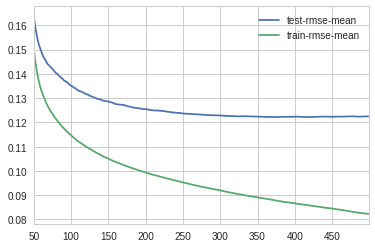

In [73]:
dtrain = xgb.DMatrix(X_select, label = Y_true)
# dtest = xgb.DMatrix(X_test)

# min_child_weight, gamma
params = {"max_depth":2, "eta":0.1}
model = xgb.cv(params, dtrain,  num_boost_round=500,  nfold=5, early_stopping_rounds=100)
model.loc[50:,["test-rmse-mean", "train-rmse-mean"]].plot()

In [28]:
lasso_cv = LassoCV(alphas = [1, 0.1, 0.001, 0.0005, 0.0001], cv=K_FOLD_NUM, 
    random_state=RAND_SEED, n_jobs=-1, )

In [29]:
lasso_cv.fit(X_train, Y_train)

LassoCV(alphas=[1, 0.1, 0.001, 0.0005, 0.0001], copy_X=True, cv=5, eps=0.001,
    fit_intercept=True, max_iter=1000, n_alphas=100, n_jobs=-1,
    normalize=False, positive=False, precompute='auto', random_state=1,
    selection='cyclic', tol=0.0001, verbose=False)

In [30]:
lasso_cv.alpha_

0.00050000000000000001

In [31]:
lasso_cv.score(X_train, Y_train)

0.93060367897473961

In [26]:
features = DataFrame({'features': X_train.columns, 'factor': np.fabs(lasso_cv.coef_)})
features[features['factor']>0].sort_values('factor', ascending=False)

,factor,features
124,6.997166e-01,RoofMatl_ClyTile
15,4.147562e-01,GrLivArea
36,2.909120e-01,MSZoning_C (all)
101,1.955967e-01,Condition2_PosN
85,1.120870e-01,Neighborhood_StoneBr
69,1.051932e-01,Neighborhood_Crawfor
78,8.343246e-02,Neighborhood_NoRidge
234,7.311358e-02,Functional_Typ
79,7.256773e-02,Neighborhood_NridgHt
2,7.247153e-02,LotArea


In [45]:
scores = rmse_cv(lasso_cv, X_train, Y_train)
print scores.mean(), scores.std()

0.122781316469 0.0166981010506


In [137]:
ridge = Ridge(random_state=RAND_SEED)
param_grid = dict(alpha=[0.01, 0.1, 1, 10, 30, 50])
ridge_grid = GridSearchCV(ridge, param_grid, scoring=rmse_scorer, cv=K_FOLD_NUM)
ridge_grid.fit(X_train, Y_true)
ridge_grid.best_score_

-0.11200617464578753

In [138]:
DataFrame(ridge_grid.cv_results_)

,mean_fit_time,mean_score_time,mean_test_score,mean_train_score,param_alpha,params,rank_test_score,split0_test_score,split0_train_score,split1_test_score,...,split2_test_score,split2_train_score,split3_test_score,split3_train_score,split4_test_score,split4_train_score,std_fit_time,std_score_time,std_test_score,std_train_score
0,0.006180,0.000446,-0.123193,-0.086738,0.01,{u'alpha': 0.01},6,-0.120851,-0.088500,-0.127593,...,-0.138656,-0.084199,-0.111956,-0.088193,-0.116918,-0.087110,0.000824,0.000032,0.009266,0.001607
1,0.005379,0.000392,-0.121233,-0.086805,0.1,{u'alpha': 0.1},5,-0.116511,-0.088565,-0.125972,...,-0.136178,-0.084288,-0.111057,-0.088266,-0.116461,-0.087156,0.000033,0.000015,0.008880,0.001601
2,0.005310,0.000371,-0.116208,-0.087822,1,{u'alpha': 1},4,-0.111577,-0.089480,-0.119936,...,-0.128224,-0.085447,-0.107035,-0.089330,-0.114283,-0.088068,0.000014,0.000003,0.007314,0.001536
3,0.005490,0.000424,-0.112006,-0.093405,10,{u'alpha': 10},1,-0.108122,-0.094701,-0.114789,...,-0.120975,-0.091282,-0.103982,-0.094852,-0.112177,-0.093555,0.000322,0.000112,0.005790,0.001334
4,0.005310,0.000377,-0.112428,-0.098478,30,{u'alpha': 30},2,-0.108124,-0.099500,-0.115156,...,-0.120949,-0.096462,-0.105100,-0.099878,-0.112825,-0.098655,0.000035,0.000003,0.005521,0.001220
5,0.005457,0.000386,-0.113226,-0.101292,50,{u'alpha': 50},3,-0.108412,-0.102272,-0.115994,...,-0.121767,-0.099259,-0.106325,-0.102700,-0.113651,-0.101466,0.000358,0.000027,0.005506,0.001215


In [37]:
X_select = X_train.ix[:, selector.support_]
ridge_grid.fit(X_select, Y_true)
ridge_grid.best_score_

-0.12027199440365655

In [35]:
lasso_grid.fit(X_select, Y_true)
lasso_grid.best_score_

-0.16951585685256193

In [38]:
X_select.shape

(1460, 50)

In [60]:
from sklearn.ensemble import GradientBoostingRegressor
param_grid = dict(n_estimators=[500, 800], max_features=[3, 4], max_depth=[1, 2])
gbr = GradientBoostingRegressor(random_state=RAND_SEED)
gbr_gscv= GridSearchCV(gbr, param_grid, scoring=rmse_scorer)

In [61]:
gbr_gscv.fit(X_select, Y_true)
gbr_gscv.best_score_

-0.12129574742497982

In [62]:
gbr_gscv.best_params_

{'max_depth': 2, 'max_features': 3, 'n_estimators': 800}

In [63]:
DataFrame(gbr_gscv.cv_results_)

,mean_fit_time,mean_score_time,mean_test_score,mean_train_score,param_max_depth,param_max_features,param_n_estimators,params,rank_test_score,split0_test_score,split0_train_score,split1_test_score,split1_train_score,split2_test_score,split2_train_score,std_fit_time,std_score_time,std_test_score,std_train_score
0,0.048327,0.001150,-0.130122,-0.110971,1,3,500,"{u'max_features': 3, u'n_estimators': 500, u'm...",8,-0.122018,-0.113447,-0.142433,-0.108034,-0.125906,-0.111433,0.001038,0.000034,0.008853,0.002234
1,0.074889,0.001683,-0.125361,-0.105019,1,3,800,"{u'max_features': 3, u'n_estimators': 800, u'm...",6,-0.115257,-0.107509,-0.138967,-0.101711,-0.121853,-0.105837,0.000468,0.000060,0.009995,0.002436
2,0.048546,0.001074,-0.128771,-0.108291,1,4,500,"{u'max_features': 4, u'n_estimators': 500, u'm...",7,-0.119855,-0.111343,-0.141875,-0.104418,-0.124576,-0.109111,0.000015,0.000004,0.009468,0.002886
3,0.076952,0.001564,-0.124616,-0.103183,1,4,800,"{u'max_features': 4, u'n_estimators': 800, u'm...",5,-0.114461,-0.105949,-0.138659,-0.099376,-0.120721,-0.104223,0.000728,0.000002,0.010258,0.002782
4,0.060552,0.001888,-0.122077,-0.089972,2,3,500,"{u'max_features': 3, u'n_estimators': 500, u'm...",3,-0.114002,-0.091497,-0.131030,-0.088032,-0.121197,-0.090387,0.000082,0.000022,0.006982,0.001445
5,0.095658,0.002888,-0.121296,-0.083227,2,3,800,"{u'max_features': 3, u'n_estimators': 800, u'm...",1,-0.112709,-0.084976,-0.130370,-0.081422,-0.120807,-0.083284,0.000168,0.000054,0.007221,0.001451
6,0.065688,0.001899,-0.122637,-0.087439,2,4,500,"{u'max_features': 4, u'n_estimators': 500, u'm...",4,-0.116026,-0.089782,-0.132353,-0.085608,-0.119525,-0.086927,0.001059,0.000020,0.007020,0.001742
7,0.101823,0.002947,-0.121615,-0.080399,2,4,800,"{u'max_features': 4, u'n_estimators': 800, u'm...",2,-0.115358,-0.082359,-0.131357,-0.079329,-0.118122,-0.079510,0.000489,0.000082,0.006984,0.001388


In [26]:
X_select.shape

(1460, 50)

In [39]:
from sklearn.ensemble import BaggingRegressor
from sklearn.tree import DecisionTreeRegressor
dtr = DecisionTreeRegressor(random_state=RAND_SEED)
param_grid = dict(max_features=[6, 7], max_depth=[18, 19], min_samples_leaf=[2])
dt_gscv= GridSearchCV(dtr, param_grid, scoring=rmse_scorer, cv=K_FOLD_NUM)
dt_gscv.fit(X_select, Y_true)
dt_gscv.best_score_

-0.20377608693210728

In [40]:
DataFrame(dt_gscv.cv_results_)

,mean_fit_time,mean_score_time,mean_test_score,mean_train_score,param_max_depth,param_max_features,param_min_samples_leaf,params,rank_test_score,split0_test_score,...,split2_test_score,split2_train_score,split3_test_score,split3_train_score,split4_test_score,split4_train_score,std_fit_time,std_score_time,std_test_score,std_train_score
0,0.002310,0.000368,-0.212184,-0.127043,18,6,2,"{u'max_features': 6, u'max_depth': 18, u'min_s...",3,-0.230731,...,-0.206786,-0.125583,-0.212604,-0.128450,-0.198738,-0.118916,0.000127,1.903389e-04,0.010527,0.004835
1,0.002611,0.000372,-0.204358,-0.112378,18,7,2,"{u'max_features': 7, u'max_depth': 18, u'min_s...",2,-0.206382,...,-0.185215,-0.109040,-0.183230,-0.107885,-0.208099,-0.108675,0.000201,1.821730e-04,0.020108,0.005760
2,0.002262,0.000240,-0.217256,-0.130921,19,6,2,"{u'max_features': 6, u'max_depth': 19, u'min_s...",4,-0.231110,...,-0.219712,-0.128637,-0.212604,-0.128450,-0.214017,-0.139853,0.000194,5.981218e-06,0.007758,0.006804
3,0.002370,0.000237,-0.203776,-0.108379,19,7,2,"{u'max_features': 7, u'max_depth': 19, u'min_s...",1,-0.204453,...,-0.184855,-0.108869,-0.183230,-0.107885,-0.209128,-0.109340,0.000065,5.761645e-07,0.019634,0.000652


In [23]:
DataFrame(dt_gscv.cv_results_)

,mean_fit_time,mean_score_time,mean_test_score,mean_train_score,param_max_depth,param_max_features,params,rank_test_score,split0_test_score,split0_train_score,...,split2_test_score,split2_train_score,split3_test_score,split3_train_score,split4_test_score,split4_train_score,std_fit_time,std_score_time,std_test_score,std_train_score
0,0.005570,0.000502,-0.225789,-0.069840,15,5,"{u'max_features': 5, u'max_depth': 15}",7,-0.211838,-0.080268,...,-0.239428,-0.068438,-0.214541,-0.064989,-0.228563,-0.077155,0.002976,0.000227,0.010882,0.007996
1,0.002472,0.000250,-0.227123,-0.066077,15,6,"{u'max_features': 6, u'max_depth': 15}",8,-0.224662,-0.064369,...,-0.245813,-0.059156,-0.212993,-0.071244,-0.215254,-0.068097,0.000178,0.000016,0.012581,0.004091
2,0.002643,0.000246,-0.207219,-0.043840,15,7,"{u'max_features': 7, u'max_depth': 15}",2,-0.193120,-0.034899,...,-0.213289,-0.048291,-0.187488,-0.040386,-0.209965,-0.054338,0.000061,0.000001,0.015863,0.006759
3,0.002393,0.000257,-0.227841,-0.063059,16,5,"{u'max_features': 5, u'max_depth': 16}",9,-0.235331,-0.066726,...,-0.228155,-0.068574,-0.211962,-0.062016,-0.230922,-0.058820,0.000034,0.000030,0.008280,0.003953
4,0.002495,0.000270,-0.219386,-0.056094,16,6,"{u'max_features': 6, u'max_depth': 16}",5,-0.216564,-0.060671,...,-0.231110,-0.049162,-0.219953,-0.053938,-0.192342,-0.057440,0.000090,0.000044,0.015401,0.004135
5,0.002708,0.000246,-0.205809,-0.040174,16,7,"{u'max_features': 7, u'max_depth': 16}",1,-0.183289,-0.043301,...,-0.221720,-0.039616,-0.211176,-0.032089,-0.197614,-0.052672,0.000036,0.000004,0.013750,0.007489
6,0.002421,0.000242,-0.210828,-0.051105,17,5,"{u'max_features': 5, u'max_depth': 17}",3,-0.228635,-0.051647,...,-0.201638,-0.065745,-0.193787,-0.039635,-0.204436,-0.052792,0.000042,0.000001,0.013801,0.008696
7,0.002479,0.000243,-0.224264,-0.039720,17,6,"{u'max_features': 6, u'max_depth': 17}",6,-0.229519,-0.045780,...,-0.216058,-0.038440,-0.225594,-0.035343,-0.213833,-0.036683,0.000032,0.000001,0.008376,0.003838
8,0.002746,0.000250,-0.213602,-0.028125,17,7,"{u'max_features': 7, u'max_depth': 17}",4,-0.218174,-0.022787,...,-0.204406,-0.021249,-0.198922,-0.026974,-0.222196,-0.034575,0.000120,0.000008,0.010095,0.005771


In [38]:
gscv.best_estimator_.max_features_

50

In [41]:
dtr = DecisionTreeRegressor(max_features=50, max_depth=50, random_state=RAND_SEED)
br = BaggingRegressor(dtr, 1000, oob_score=True, random_state=RAND_SEED)
br.fit(X_train, Y_true)
br.oob_score_

0.87773594760998375

In [96]:
dtr = DecisionTreeRegressor(random_state=RAND_SEED)
br = BaggingRegressor(dtr, random_state=RAND_SEED)
param_grid = dict(n_estimators=[1000], base_estimator__max_features = [7], base_estimator__max_depth=[15])
br_gscv= GridSearchCV(br, param_grid, scoring=rmse_scorer, cv=K_FOLD_NUM)
br_gscv.fit(X_train, Y_true)
br_gscv.best_score_

-0.1540743755562253

In [97]:
DataFrame(br_gscv.cv_results_)

,mean_fit_time,mean_score_time,mean_test_score,mean_train_score,param_base_estimator__max_depth,param_base_estimator__max_features,param_n_estimators,params,rank_test_score,split0_test_score,...,split2_test_score,split2_train_score,split3_test_score,split3_train_score,split4_test_score,split4_train_score,std_fit_time,std_score_time,std_test_score,std_train_score
0,2.065514,0.125683,-0.154074,-0.069895,15,7,1000,"{u'n_estimators': 1000, u'base_estimator__max_...",1,-0.143291,...,-0.160054,-0.069265,-0.146945,-0.070209,-0.150675,-0.070365,0.020749,0.000654,0.009495,0.000664


In [104]:
X_train.shape

(1456, 287)

In [107]:
rf = RandomForestRegressor()
param_grid = dict(n_estimators=[300], max_features = [10, 13, 15], max_depth=[5, 15, 25])
rf_gscv = GridSearchCV(rf, param_grid, scoring=rmse_scorer, cv=K_FOLD_NUM)
rf_gscv.fit(X_train, Y_true)
rf_gscv.best_score_

-0.14139557362099908

In [108]:
DataFrame(rf_gscv.cv_results_).sort_values('rank_test_score')

,mean_fit_time,mean_score_time,mean_test_score,mean_train_score,param_max_depth,param_max_features,param_n_estimators,params,rank_test_score,split0_test_score,...,split2_test_score,split2_train_score,split3_test_score,split3_train_score,split4_test_score,split4_train_score,std_fit_time,std_score_time,std_test_score,std_train_score
8,0.858981,0.111176,-0.141396,-0.053268,25,15,300,"{u'max_features': 15, u'n_estimators': 300, u'...",1,-0.131203,...,-0.148692,-0.052452,-0.134039,-0.053284,-0.138137,-0.054035,0.012473,0.000226,0.009005,0.000501
5,0.813806,0.110183,-0.143046,-0.057620,15,15,300,"{u'max_features': 15, u'n_estimators': 300, u'...",2,-0.132356,...,-0.149321,-0.056630,-0.137129,-0.057534,-0.139291,-0.058485,0.011264,0.000407,0.008970,0.000602
7,0.817353,0.111224,-0.143899,-0.053626,25,13,300,"{u'max_features': 13, u'n_estimators': 300, u'...",3,-0.133100,...,-0.150866,-0.053349,-0.137387,-0.053906,-0.140397,-0.053730,0.011581,0.000256,0.009085,0.000231
4,0.771261,0.110244,-0.144912,-0.059021,15,13,300,"{u'max_features': 13, u'n_estimators': 300, u'...",4,-0.132939,...,-0.151352,-0.058802,-0.139745,-0.058947,-0.140895,-0.059660,0.006351,0.000190,0.009442,0.000390
6,0.757427,0.113108,-0.146307,-0.054880,25,10,300,"{u'max_features': 10, u'n_estimators': 300, u'...",5,-0.136712,...,-0.152506,-0.053895,-0.137924,-0.055433,-0.142446,-0.055204,0.003766,0.000547,0.009606,0.000577
3,0.725518,0.109968,-0.148272,-0.062632,15,10,300,"{u'max_features': 10, u'n_estimators': 300, u'...",6,-0.137415,...,-0.156573,-0.061898,-0.140841,-0.063158,-0.144193,-0.062699,0.019880,0.000231,0.009567,0.000699
2,0.567578,0.106794,-0.179622,-0.160356,5,15,300,"{u'max_features': 15, u'n_estimators': 300, u'...",7,-0.168486,...,-0.185721,-0.160796,-0.175130,-0.161825,-0.174415,-0.159121,0.019889,0.004177,0.009239,0.001736
1,0.530021,0.103062,-0.184663,-0.166247,5,13,300,"{u'max_features': 13, u'n_estimators': 300, u'...",8,-0.174208,...,-0.188407,-0.163600,-0.179380,-0.168250,-0.178816,-0.164424,0.000763,0.000327,0.010050,0.002396
0,0.521033,0.102552,-0.193173,-0.176187,5,10,300,"{u'max_features': 10, u'n_estimators': 300, u'...",9,-0.181766,...,-0.200012,-0.175511,-0.185136,-0.176984,-0.189963,-0.178500,0.010765,0.000263,0.010032,0.002216


In [122]:
et = ExtraTreesRegressor()
param_grid = dict(n_estimators=[500], max_features = [10, 13, 15], max_depth=[10, 15, 25])
et_gscv = GridSearchCV(et, param_grid, scoring=rmse_scorer, cv=K_FOLD_NUM, n_jobs=-1)
et_gscv.fit(X_train, Y_true)
et_gscv.best_score_

-0.14968937140990415

In [123]:
DataFrame(et_gscv.cv_results_).sort_values('rank_test_score')

,mean_fit_time,mean_score_time,mean_test_score,mean_train_score,param_max_depth,param_max_features,param_n_estimators,params,rank_test_score,split0_test_score,...,split2_test_score,split2_train_score,split3_test_score,split3_train_score,split4_test_score,split4_train_score,std_fit_time,std_score_time,std_test_score,std_train_score
8,2.052162,0.235485,-0.149689,-0.002727,25,15,500,"{u'max_features': 15, u'n_estimators': 500, u'...",1,-0.139377,...,-0.157907,-0.002985,-0.140681,-0.002683,-0.145261,-0.002492,0.180318,0.048726,0.010168,0.000179
7,2.787637,0.303667,-0.151038,-0.003269,25,13,500,"{u'max_features': 13, u'n_estimators': 500, u'...",2,-0.141979,...,-0.157559,-0.003764,-0.142523,-0.003133,-0.144303,-0.003375,0.022979,0.006374,0.010582,0.000288
5,2.490105,0.295945,-0.152064,-0.036632,15,15,500,"{u'max_features': 15, u'n_estimators': 500, u'...",3,-0.141629,...,-0.160318,-0.037235,-0.143105,-0.036805,-0.147453,-0.036912,0.023731,0.002323,0.010275,0.000504
6,2.565755,0.312030,-0.154057,-0.004345,25,10,500,"{u'max_features': 10, u'n_estimators': 500, u'...",4,-0.144935,...,-0.160715,-0.004309,-0.145154,-0.004366,-0.149096,-0.004143,0.039525,0.006618,0.009990,0.000197
4,2.358673,0.297575,-0.154791,-0.040135,15,13,500,"{u'max_features': 13, u'n_estimators': 500, u'...",5,-0.144336,...,-0.161923,-0.040745,-0.146532,-0.039948,-0.149801,-0.040432,0.024073,0.003523,0.010288,0.000690
3,2.208870,0.292572,-0.159229,-0.046834,15,10,500,"{u'max_features': 10, u'n_estimators': 500, u'...",6,-0.149185,...,-0.164150,-0.046896,-0.151403,-0.047046,-0.154217,-0.047911,0.026778,0.003144,0.010346,0.001078
2,2.025953,0.284220,-0.164191,-0.093927,10,15,500,"{u'max_features': 15, u'n_estimators': 500, u'...",7,-0.152816,...,-0.169392,-0.093512,-0.157056,-0.094852,-0.160811,-0.094437,0.018697,0.001953,0.009988,0.001462
1,1.945989,0.280309,-0.167304,-0.099415,10,13,500,"{u'max_features': 13, u'n_estimators': 500, u'...",8,-0.156403,...,-0.172133,-0.099364,-0.160030,-0.099786,-0.162652,-0.099916,0.009079,0.003190,0.010412,0.001508
0,1.855201,0.279197,-0.174754,-0.110158,10,10,500,"{u'max_features': 10, u'n_estimators': 500, u'...",9,-0.163519,...,-0.179902,-0.109991,-0.166248,-0.111350,-0.171153,-0.110814,0.020587,0.000567,0.010682,0.001753


In [119]:
DataFrame(et_gscv.cv_results_).sort_values('rank_test_score')

,mean_fit_time,mean_score_time,mean_test_score,mean_train_score,param_max_depth,param_max_features,param_n_estimators,params,rank_test_score,split0_test_score,...,split2_test_score,split2_train_score,split3_test_score,split3_train_score,split4_test_score,split4_train_score,std_fit_time,std_score_time,std_test_score,std_train_score
4,0.881512,0.114484,-0.149607,-0.002461,25,sqrt,300,"{u'max_features': u'sqrt', u'n_estimators': 30...",1,-0.140371,...,-0.157583,-0.002493,-0.140413,-0.002439,-0.144855,-0.002359,0.001440,0.000370,0.009881,0.000093
2,0.777272,0.111114,-0.151123,-0.035402,15,sqrt,300,"{u'max_features': u'sqrt', u'n_estimators': 30...",2,-0.141653,...,-0.158943,-0.036038,-0.142319,-0.035505,-0.144815,-0.036886,0.001437,0.000182,0.010489,0.001061
5,0.709869,0.120183,-0.158820,-0.005825,25,log2,300,"{u'max_features': u'log2', u'n_estimators': 30...",3,-0.148770,...,-0.164588,-0.005947,-0.148987,-0.005786,-0.154563,-0.006144,0.001297,0.010917,0.010843,0.000272
3,0.635052,0.110733,-0.163278,-0.054362,15,log2,300,"{u'max_features': u'log2', u'n_estimators': 30...",4,-0.154367,...,-0.168921,-0.054198,-0.155140,-0.054763,-0.157814,-0.055292,0.010738,0.000267,0.009928,0.000621
0,0.513628,0.102998,-0.205553,-0.188921,5,sqrt,300,"{u'max_features': u'sqrt', u'n_estimators': 30...",5,-0.191138,...,-0.211407,-0.187505,-0.197250,-0.191837,-0.202211,-0.189872,0.010698,0.000153,0.012106,0.002222
1,0.472318,0.102996,-0.228771,-0.216212,5,log2,300,"{u'max_features': u'log2', u'n_estimators': 30...",6,-0.216968,...,-0.233529,-0.215518,-0.218081,-0.218366,-0.223858,-0.216252,0.009830,0.000298,0.012769,0.002790


In [65]:
ridge = Ridge(alpha=1, random_state=RAND_SEED)
abr = AdaBoostRegressor(ridge, random_state=RAND_SEED)
param_grid = dict(n_estimators=[10, 20, 50], learning_rate=[0.001, 0.1])
abr_gscv= GridSearchCV(abr, param_grid, scoring=rmse_scorer, cv=K_FOLD_NUM, refit=False)
abr_gscv.fit(X_select, Y_true)
abr_gscv.best_score_

-0.11970355477917248

In [51]:
from sklearn.feature_selection import RFE
estimator = Ridge(alpha=10, random_state=RAND_SEED)
selector = RFE(estimator, n_features_to_select=150)
selector.fit(X_train, Y_true)
X_train_select = X_train.ix[:, selector.support_]
X_test_select = X_test.ix[:, selector.support_]

In [68]:
import ensemble
reload(ensemble)

<module 'ensemble' from '../../useful_code/ensemble.py'>

In [55]:
from ensemble import Ensemble


base_models = [
    xgb.XGBRegressor(max_depth=5, n_estimators=1000, min_child_weight=4, 
        learning_rate=0.0015, gamma=0.04, colsample_bytree=0.2, reg_lambda=0.5, seed=RAND_SEED),
    Lasso(alpha=0.0005, random_state=RAND_SEED),
#     Ridge(alpha=10, random_state=RAND_SEED),
    RandomForestRegressor(n_estimators=500, max_features=15, max_depth=25,  random_state=RAND_SEED),
    ExtraTreesRegressor(n_estimators=500, max_features=13, max_depth=25, random_state=RAND_SEED)
]


# stacker = Pipeline([('polyfeature', PolynomialFeatures(5)),  
#     ('ridge', Ridge(random_state=RAND_SEED))])

# param_grid = dict(ridge__alpha=[0.01, 0.1, 0.5, 1, 5])


stacker = Ridge(random_state=RAND_SEED)
param_grid = dict(alpha=[0.005, 0.01, 0.1]) 

ensemble_model = Ensemble(n_folds=5, 
    stacker=stacker,
    base_models=base_models,
    param_grid = param_grid,
)

# param_grid = dict(n_estimators=[100, 300], learning_rate=[0.015, 0.025, 0.05])

# ensemble_model = Ensemble(n_folds=5, 
#     stacker=GradientBoostingRegressor(random_state=RAND_SEED),
#     base_models=base_models,
#     param_grid = param_grid
# )

In [56]:
Y_pred = ensemble_model.fit_predict(X_train_select, Y_true, X_test_select)

Fitting For Base Model #1 / 4 ---
--- Fitting For Fold #1 / 5 ---
Elapsed: 64.28 minutes ---
--- Fitting For Fold #2 / 5 ---
Elapsed: 64.28 minutes ---
--- Fitting For Fold #3 / 5 ---
Elapsed: 64.28 minutes ---
--- Fitting For Fold #4 / 5 ---
Elapsed: 64.29 minutes ---
--- Fitting For Fold #5 / 5 ---
Elapsed: 64.29 minutes ---
Elapsed: 64.29 minutes ---
Fitting For Base Model #2 / 4 ---
--- Fitting For Fold #1 / 5 ---
Elapsed: 64.29 minutes ---
--- Fitting For Fold #2 / 5 ---
Elapsed: 64.29 minutes ---
--- Fitting For Fold #3 / 5 ---
Elapsed: 64.29 minutes ---
--- Fitting For Fold #4 / 5 ---
Elapsed: 64.29 minutes ---
--- Fitting For Fold #5 / 5 ---
Elapsed: 64.29 minutes ---
Elapsed: 64.29 minutes ---
Fitting For Base Model #3 / 4 ---
--- Fitting For Fold #1 / 5 ---
Elapsed: 64.33 minutes ---
--- Fitting For Fold #2 / 5 ---
Elapsed: 64.36 minutes ---
--- Fitting For Fold #3 / 5 ---
Elapsed: 64.39 minutes ---
--- Fitting For Fold #4 / 5 ---
Elapsed: 64.42 minutes ---
--- Fitting For Fo

[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   6 out of   6 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   7 out of   7 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   8 out of   8 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   9 out of   9 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done  11 out of  11 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done  12 out of  12 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done  13 out of  1

In [54]:
DataFrame(ensemble_model.stacker_grid_cv.cv_results_).sort_values('rank_test_score')

,mean_fit_time,mean_score_time,mean_test_score,mean_train_score,param_alpha,params,rank_test_score,split0_test_score,split0_train_score,split1_test_score,...,split2_test_score,split2_train_score,split3_test_score,split3_train_score,split4_test_score,split4_train_score,std_fit_time,std_score_time,std_test_score,std_train_score
2,0.000342,0.000110,-0.106904,-0.106551,0.05,{u'alpha': 0.05},1,-0.101884,-0.107867,-0.110092,...,-0.118617,-0.103463,-0.099497,-0.108398,-0.104445,-0.107235,0.000001,5.135693e-07,0.006832,0.001773
3,0.000352,0.000110,-0.106904,-0.106555,0.1,{u'alpha': 0.1},2,-0.101886,-0.107871,-0.110093,...,-0.118555,-0.103468,-0.099540,-0.108401,-0.104463,-0.107239,0.000017,5.840039e-07,0.006800,0.001773
1,0.000353,0.000110,-0.106905,-0.106550,0.01,{u'alpha': 0.01},3,-0.101884,-0.107866,-0.110094,...,-0.118671,-0.103461,-0.099463,-0.108397,-0.104432,-0.107233,0.000016,3.989506e-07,0.006859,0.001773
0,0.000356,0.000111,-0.106906,-0.106550,0.005,{u'alpha': 0.005},4,-0.101884,-0.107866,-0.110095,...,-0.118678,-0.103461,-0.099458,-0.108397,-0.104430,-0.107233,0.000023,4.307400e-06,0.006863,0.001773


In [36]:
DataFrame(ensemble_model.stacker_grid_cv.cv_results_).sort_values('rank_test_score')

,mean_fit_time,mean_score_time,mean_test_score,mean_train_score,param_alpha,params,rank_test_score,split0_test_score,split0_train_score,split1_test_score,...,split2_test_score,split2_train_score,split3_test_score,split3_train_score,split4_test_score,split4_train_score,std_fit_time,std_score_time,std_test_score,std_train_score
2,0.000338,0.000094,-0.107952,-0.107695,0.05,{u'alpha': 0.05},1,-0.103039,-0.108942,-0.108605,...,-0.121071,-0.104227,-0.102221,-0.109152,-0.104842,-0.108549,0.000017,1.049042e-06,0.006915,0.001813
1,0.000343,0.000094,-0.107953,-0.107693,0.01,{u'alpha': 0.01},2,-0.103064,-0.108940,-0.108585,...,-0.121116,-0.104225,-0.102200,-0.109151,-0.104816,-0.108547,0.000015,8.395585e-07,0.006934,0.001813
0,0.000347,0.000096,-0.107953,-0.107693,0.005,{u'alpha': 0.005},3,-0.103067,-0.108940,-0.108583,...,-0.121122,-0.104225,-0.102198,-0.109151,-0.104813,-0.108547,0.000037,3.651464e-06,0.006937,0.001813
3,0.000356,0.000095,-0.107954,-0.107698,0.1,{u'alpha': 0.1},4,-0.103013,-0.108946,-0.108632,...,-0.121018,-0.104231,-0.102247,-0.109155,-0.104877,-0.108552,0.000027,1.059824e-06,0.006892,0.001813


In [31]:
DataFrame(ensemble_model.stacker_grid_cv.cv_results_).sort_values('rank_test_score')

,mean_fit_time,mean_score_time,mean_test_score,mean_train_score,param_ridge__alpha,params,rank_test_score,split0_test_score,split0_train_score,split1_test_score,...,split2_test_score,split2_train_score,split3_test_score,split3_train_score,split4_test_score,split4_train_score,std_fit_time,std_score_time,std_test_score,std_train_score
4,0.002701,0.000972,-0.110106,-0.104534,5,{u'ridge__alpha': 5},1,-0.110346,-0.105735,-0.115091,...,-0.117174,-0.102341,-0.102068,-0.105926,-0.105853,-0.104883,0.000050,0.000008,0.005612,0.001332
3,0.002692,0.000966,-0.111626,-0.104149,1,{u'ridge__alpha': 1},2,-0.115738,-0.105116,-0.117475,...,-0.116758,-0.102177,-0.102003,-0.105612,-0.106145,-0.104463,0.000028,0.000004,0.006325,0.001238
2,0.002705,0.000973,-0.112566,-0.103956,0.5,{u'ridge__alpha': 0.5},3,-0.118798,-0.104856,-0.119104,...,-0.116572,-0.102123,-0.102026,-0.105431,-0.106307,-0.104216,0.000015,0.000009,0.007041,0.001188
1,0.002711,0.000975,-0.113917,-0.103388,0.1,{u'ridge__alpha': 0.1},4,-0.123058,-0.104205,-0.121850,...,-0.115806,-0.101948,-0.102037,-0.104800,-0.106803,-0.103420,0.000016,0.000007,0.008269,0.001040
0,0.002930,0.000995,-0.115415,-0.102738,0.01,{u'ridge__alpha': 0.01},5,-0.128297,-0.103583,-0.122702,...,-0.115225,-0.101513,-0.102832,-0.103913,-0.107974,-0.102608,0.000429,0.000046,0.009307,0.000900


In [28]:
DataFrame(ensemble_model.stacker_grid_cv.cv_results_).sort_values('rank_test_score')

,mean_fit_time,mean_score_time,mean_test_score,mean_train_score,param_ridge__alpha,params,rank_test_score,split0_test_score,split0_train_score,split1_test_score,...,split2_test_score,split2_train_score,split3_test_score,split3_train_score,split4_test_score,split4_train_score,std_fit_time,std_score_time,std_test_score,std_train_score
2,0.000691,0.000234,-0.108409,-0.107781,1,{u'ridge__alpha': 1},1,-0.104672,-0.108713,-0.111248,...,-0.118923,-0.105045,-0.101021,-0.109568,-0.106194,-0.108403,0.000005,0.000004,0.006196,0.001569
1,0.000729,0.000232,-0.108431,-0.107687,0.5,{u'ridge__alpha': 0.5},2,-0.105082,-0.108573,-0.111068,...,-0.118846,-0.104957,-0.101063,-0.109445,-0.106106,-0.108326,0.000049,0.000006,0.006103,0.001552
3,0.000705,0.000232,-0.108436,-0.107973,5,{u'ridge__alpha': 5},3,-0.104030,-0.109083,-0.111559,...,-0.119118,-0.105189,-0.101116,-0.109762,-0.106374,-0.108564,0.000025,0.000001,0.006341,0.001614
0,0.000703,0.000234,-0.108605,-0.107509,0.1,{u'ridge__alpha': 0.1},4,-0.105912,-0.108393,-0.110686,...,-0.118921,-0.104741,-0.101528,-0.109168,-0.105986,-0.108174,0.000041,0.000008,0.005914,0.001538


In [25]:
DataFrame(ensemble_model.stacker_grid_cv.cv_results_).sort_values('rank_test_score')

,mean_fit_time,mean_score_time,mean_test_score,mean_train_score,param_ridge__alpha,params,rank_test_score,split0_test_score,split0_train_score,split1_test_score,...,split2_test_score,split2_train_score,split3_test_score,split3_train_score,split4_test_score,split4_train_score,std_fit_time,std_score_time,std_test_score,std_train_score
3,0.000690,0.000232,-0.108605,-0.107509,0.1,{u'ridge__alpha': 0.1},1,-0.105912,-0.108393,-0.110686,...,-0.118921,-0.104741,-0.101528,-0.109168,-0.105986,-0.108174,0.000007,2.825034e-06,0.005914,0.001538
2,0.000694,0.000231,-0.109067,-0.107344,0.01,{u'ridge__alpha': 0.01},2,-0.107233,-0.108199,-0.110353,...,-0.119449,-0.104542,-0.102181,-0.108965,-0.106123,-0.108004,0.000010,8.869684e-07,0.005810,0.001533
1,0.000713,0.000231,-0.109220,-0.107314,0.005,{u'ridge__alpha': 0.005},3,-0.107720,-0.108149,-0.110321,...,-0.119587,-0.104514,-0.102289,-0.108937,-0.106189,-0.107979,0.000039,1.385292e-06,0.005798,0.001531
0,0.024695,0.000255,-0.109587,-0.107252,0.001,{u'ridge__alpha': 0.001},4,-0.108971,-0.108029,-0.110335,...,-0.119876,-0.104448,-0.102465,-0.108882,-0.106289,-0.107932,0.047963,4.764951e-05,0.005802,0.001527


In [33]:
DataFrame(ensemble_model.stacker_grid_cv.cv_results_).sort_values('rank_test_score')

,mean_fit_time,mean_score_time,mean_test_score,mean_train_score,param_ridge__alpha,params,rank_test_score,split0_test_score,split0_train_score,split1_test_score,...,split2_test_score,split2_train_score,split3_test_score,split3_train_score,split4_test_score,split4_train_score,std_fit_time,std_score_time,std_test_score,std_train_score
4,0.000607,0.000198,-0.108305,-0.107635,0.1,{u'ridge__alpha': 0.1},1,-0.104857,-0.108507,-0.110899,...,-0.118980,-0.104831,-0.100794,-0.109449,-0.106005,-0.108290,0.000005,4.422006e-07,0.006232,0.001589
3,0.000621,0.000198,-0.108697,-0.107521,0.01,{u'ridge__alpha': 0.01},2,-0.106623,-0.108250,-0.110612,...,-0.119344,-0.104723,-0.100973,-0.109348,-0.105937,-0.108223,0.000034,1.196852e-06,0.006140,0.001575
2,0.000614,0.000198,-0.108737,-0.107515,0.008,{u'ridge__alpha': 0.008},3,-0.106782,-0.108237,-0.110600,...,-0.119374,-0.104720,-0.100994,-0.109341,-0.105941,-0.108217,0.000012,1.044698e-06,0.006134,0.001573
1,0.000628,0.000198,-0.108812,-0.107502,0.005,{u'ridge__alpha': 0.005},4,-0.107079,-0.108210,-0.110576,...,-0.119426,-0.104714,-0.101034,-0.109324,-0.105951,-0.108203,0.000036,3.693565e-07,0.006121,0.001567
0,0.019565,0.000218,-0.108991,-0.107447,0.001,{u'ridge__alpha': 0.001},5,-0.107755,-0.108123,-0.110482,...,-0.119521,-0.104688,-0.101179,-0.109246,-0.106021,-0.108136,0.037840,4.004535e-05,0.006072,0.001545


In [170]:
ensemble_model.stacker_grid_cv.best_estimator_.coef_

array([-0.26600573,  0.81112504,  0.48931326, -0.12232077])

In [166]:
DataFrame(ensemble_model.stacker_grid_cv.cv_results_).sort_values('rank_test_score')

,mean_fit_time,mean_score_time,mean_test_score,mean_train_score,param_alpha,params,rank_test_score,split0_test_score,split0_train_score,split1_test_score,...,split2_test_score,split2_train_score,split3_test_score,split3_train_score,split4_test_score,split4_train_score,std_fit_time,std_score_time,std_test_score,std_train_score
3,0.000319,0.000092,-0.108074,-0.107683,0.01,{u'alpha': 0.01},1,-0.104034,-0.108758,-0.110600,...,-0.119104,-0.104783,-0.100842,-0.109447,-0.105801,-0.108328,0.000024,4.672031e-07,0.006352,0.001639
2,0.000329,0.000092,-0.108074,-0.107683,0.008,{u'alpha': 0.008},2,-0.104033,-0.108758,-0.110601,...,-0.119107,-0.104783,-0.100840,-0.109447,-0.105800,-0.108328,0.000025,5.001110e-07,0.006354,0.001639
1,0.000324,0.000092,-0.108074,-0.107683,0.005,{u'alpha': 0.005},3,-0.104032,-0.108758,-0.110601,...,-0.119113,-0.104783,-0.100837,-0.109447,-0.105800,-0.108328,0.000016,6.031566e-07,0.006357,0.001639
0,0.000329,0.000094,-0.108074,-0.107683,0.001,{u'alpha': 0.001},4,-0.104031,-0.108758,-0.110601,...,-0.119119,-0.104783,-0.100833,-0.109447,-0.105799,-0.108328,0.000037,2.986996e-06,0.006360,0.001639
4,0.000318,0.000091,-0.108077,-0.107693,0.1,{u'alpha': 0.1},5,-0.104062,-0.108766,-0.110606,...,-0.118973,-0.104796,-0.100935,-0.109456,-0.105823,-0.108338,0.000017,4.156970e-07,0.006281,0.001637


In [163]:
DataFrame(ensemble_model.stacker_grid_cv.cv_results_).sort_values('rank_test_score')

,mean_fit_time,mean_score_time,mean_test_score,mean_train_score,param_learning_rate,param_n_estimators,params,rank_test_score,split0_test_score,split0_train_score,...,split2_test_score,split2_train_score,split3_test_score,split3_train_score,split4_test_score,split4_train_score,std_fit_time,std_score_time,std_test_score,std_train_score
1,0.093373,0.001096,-0.113627,-0.091588,0.015,300,"{u'n_estimators': 300, u'learning_rate': 0.015}",1,-0.108399,-0.092415,...,-0.119692,-0.090024,-0.116442,-0.092578,-0.108368,-0.092400,0.000754,0.000041,0.004524,0.001087
4,0.033945,0.000601,-0.113795,-0.090240,0.05,100,"{u'n_estimators': 100, u'learning_rate': 0.05}",2,-0.108531,-0.091383,...,-0.119387,-0.088641,-0.116756,-0.090967,-0.109141,-0.091276,0.003845,0.000078,0.004274,0.001198
3,0.103516,0.001372,-0.115431,-0.085678,0.025,300,"{u'n_estimators': 300, u'learning_rate': 0.025}",3,-0.111183,-0.086893,...,-0.119879,-0.083665,-0.122256,-0.086458,-0.108973,-0.087204,0.010150,0.000410,0.005028,0.001465
2,0.032505,0.000510,-0.116104,-0.103089,0.025,100,"{u'n_estimators': 100, u'learning_rate': 0.025}",4,-0.109321,-0.103806,...,-0.123954,-0.101558,-0.112326,-0.104047,-0.109694,-0.104100,0.000533,0.000019,0.007023,0.001108
5,0.090845,0.000987,-0.117632,-0.074757,0.05,300,"{u'n_estimators': 300, u'learning_rate': 0.05}",5,-0.114108,-0.076345,...,-0.121796,-0.073007,-0.125234,-0.074794,-0.110631,-0.076697,0.001452,0.000073,0.005254,0.001591
0,0.032388,0.000465,-0.141777,-0.134814,0.015,100,"{u'n_estimators': 100, u'learning_rate': 0.015}",6,-0.131563,-0.135759,...,-0.148611,-0.133224,-0.138060,-0.136118,-0.131642,-0.135846,0.000066,0.000008,0.010638,0.001346


In [127]:
DataFrame(ensemble_model.stacker_grid_cv.cv_results_)

,mean_fit_time,mean_score_time,mean_test_score,mean_train_score,param_alpha,params,rank_test_score,split0_test_score,split0_train_score,split1_test_score,...,split2_test_score,split2_train_score,split3_test_score,split3_train_score,split4_test_score,split4_train_score,std_fit_time,std_score_time,std_test_score,std_train_score
0,0.000331,0.000095,-0.108074,-0.107683,0.001,{u'alpha': 0.001},2,-0.104031,-0.108758,-0.110601,...,-0.119119,-0.104783,-0.100833,-0.109447,-0.105799,-0.108328,0.000036,5.833026e-06,0.006360,0.001639
1,0.000318,0.000093,-0.108074,-0.107683,0.01,{u'alpha': 0.01},1,-0.104034,-0.108758,-0.110600,...,-0.119104,-0.104783,-0.100842,-0.109447,-0.105801,-0.108328,0.000018,1.348699e-06,0.006352,0.001639
2,0.000318,0.000092,-0.108077,-0.107693,0.1,{u'alpha': 0.1},3,-0.104062,-0.108766,-0.110606,...,-0.118973,-0.104796,-0.100935,-0.109456,-0.105823,-0.108338,0.000009,7.629395e-07,0.006281,0.001637


In [114]:
DataFrame(ensemble_model.stacker_grid_cv.cv_results_)

,mean_fit_time,mean_score_time,mean_test_score,mean_train_score,param_alpha,params,rank_test_score,split0_test_score,split0_train_score,split1_test_score,...,split2_test_score,split2_train_score,split3_test_score,split3_train_score,split4_test_score,split4_train_score,std_fit_time,std_score_time,std_test_score,std_train_score
0,0.000334,0.000095,-0.108375,-0.107785,0.001,{u'alpha': 0.001},3,-0.104625,-0.108785,-0.110906,...,-0.119678,-0.104889,-0.101169,-0.109536,-0.105511,-0.108541,0.000034,3.821843e-06,0.006454,0.001637
1,0.000324,0.000093,-0.108367,-0.107786,0.01,{u'alpha': 0.01},2,-0.104640,-0.108785,-0.110913,...,-0.119592,-0.104890,-0.101192,-0.109536,-0.105513,-0.108541,0.000013,7.599534e-07,0.006417,0.001636
2,0.000336,0.000093,-0.108333,-0.107814,0.1,{u'alpha': 0.1},1,-0.104759,-0.108801,-0.110966,...,-0.118996,-0.104950,-0.101396,-0.109553,-0.105560,-0.108568,0.000030,8.176054e-07,0.006150,0.001622


In [111]:
DataFrame(ensemble_model.stacker_grid_cv.cv_results_)

,mean_fit_time,mean_score_time,mean_test_score,mean_train_score,param_alpha,params,rank_test_score,split0_test_score,split0_train_score,split1_test_score,...,split2_test_score,split2_train_score,split3_test_score,split3_train_score,split4_test_score,split4_train_score,std_fit_time,std_score_time,std_test_score,std_train_score
0,0.000334,0.000094,-0.108154,-0.107813,0.001,{u'alpha': 0.001},3,-0.104385,-0.108816,-0.110851,...,-0.119021,-0.104962,-0.101014,-0.109557,-0.105512,-0.108541,0.000031,3.322840e-06,0.006284,0.001618
1,0.000324,0.000091,-0.108153,-0.107813,0.01,{u'alpha': 0.01},2,-0.104380,-0.108816,-0.110848,...,-0.119012,-0.104962,-0.101020,-0.109557,-0.105520,-0.108541,0.000019,4.156970e-07,0.006279,0.001618
2,0.000315,0.000091,-0.108148,-0.107815,0.1,{u'alpha': 0.1},1,-0.104325,-0.108819,-0.110823,...,-0.118930,-0.104965,-0.101082,-0.109559,-0.105593,-0.108543,0.000008,5.519789e-07,0.006236,0.001618


In [93]:
DataFrame(ensemble_model.stacker_grid_cv.cv_results_)

,mean_fit_time,mean_score_time,mean_test_score,mean_train_score,param_alpha,params,rank_test_score,split0_test_score,split0_train_score,split1_test_score,...,split2_test_score,split2_train_score,split3_test_score,split3_train_score,split4_test_score,split4_train_score,std_fit_time,std_score_time,std_test_score,std_train_score
0,0.000325,0.000109,-0.109898,-0.109423,0.001,{u'alpha': 0.001},3,-0.105937,-0.110480,-0.111036,...,-0.120260,-0.106767,-0.103631,-0.110940,-0.108641,-0.109765,0.000016,0.000003,0.005747,0.001460
1,0.000575,0.000113,-0.109893,-0.109424,0.01,{u'alpha': 0.01},2,-0.105953,-0.110481,-0.111049,...,-0.120194,-0.106768,-0.103646,-0.110940,-0.108636,-0.109765,0.000491,0.000007,0.005719,0.001460
2,0.000317,0.000109,-0.109869,-0.109446,0.1,{u'alpha': 0.1},1,-0.106072,-0.110492,-0.111160,...,-0.119745,-0.106815,-0.103770,-0.110955,-0.108613,-0.109788,0.000003,0.000001,0.005520,0.001448


In [72]:
DataFrame(ensemble_model.stacker_grid_cv.cv_results_)

,mean_fit_time,mean_score_time,mean_test_score,mean_train_score,param_alpha,params,rank_test_score,split0_test_score,split0_train_score,split1_test_score,...,split2_test_score,split2_train_score,split3_test_score,split3_train_score,split4_test_score,split4_train_score,std_fit_time,std_score_time,std_test_score,std_train_score
0,0.000332,0.000112,-0.109742,-0.109483,0.001,{u'alpha': 0.001},3,-0.105541,-0.110595,-0.110847,...,-0.120096,-0.106772,-0.103503,-0.111009,-0.108738,-0.109787,2.010614e-05,4.067396e-06,0.005761,0.001487
1,0.000317,0.000110,-0.109742,-0.109483,0.01,{u'alpha': 0.01},2,-0.105536,-0.110595,-0.110847,...,-0.120092,-0.106772,-0.103507,-0.111009,-0.108742,-0.109787,8.894004e-06,2.861023e-07,0.005759,0.001487
2,0.000313,0.000110,-0.109742,-0.109484,0.1,{u'alpha': 0.1},1,-0.105489,-0.110596,-0.110851,...,-0.120054,-0.106773,-0.103547,-0.111010,-0.108783,-0.109788,6.810597e-07,6.143617e-07,0.005743,0.001487


In [73]:
ensemble_model.stacker_grid_cv.best_estimator_.coef_

array([ 0.02492294,  0.98795563])

# Predictions

In [25]:
X_test = df_all_feed.iloc[train_max_col:]

In [80]:
DataFrame(ensemble_model.stacker_grid_cv.cv_results_)

,mean_fit_time,mean_score_time,mean_test_score,mean_train_score,param_alpha,params,rank_test_score,split0_test_score,split0_train_score,split1_test_score,...,split2_test_score,split2_train_score,split3_test_score,split3_train_score,split4_test_score,split4_train_score,std_fit_time,std_score_time,std_test_score,std_train_score
0,0.000325,0.000112,-0.109742,-0.109483,0.001,{u'alpha': 0.001},3,-0.105541,-0.110595,-0.110847,...,-0.120096,-0.106772,-0.103503,-0.111009,-0.108738,-0.109787,0.000021,3.088050e-06,0.005761,0.001487
1,0.000314,0.000109,-0.109742,-0.109483,0.01,{u'alpha': 0.01},2,-0.105536,-0.110595,-0.110847,...,-0.120092,-0.106772,-0.103507,-0.111009,-0.108742,-0.109787,0.000002,5.001110e-07,0.005759,0.001487
2,0.000314,0.000110,-0.109742,-0.109484,0.1,{u'alpha': 0.1},1,-0.105489,-0.110596,-0.110851,...,-0.120054,-0.106773,-0.103547,-0.111010,-0.108783,-0.109788,0.000003,6.843901e-07,0.005743,0.001487


In [59]:
Y_pred = np.exp(Y_pred)

In [49]:
Series(Y_pred).describe()

count      1459.000000
mean     178796.074698
std       79696.322111
min       42635.629050
25%      127415.738787
50%      157411.114095
75%      209899.553365
max      873915.214271
dtype: float64

In [60]:
Series(Y_pred).describe()

count      1459.000000
mean     179141.866624
std       80300.883632
min       44635.553946
25%      127640.229487
50%      157760.633850
75%      210358.487339
max      880581.614084
dtype: float64

In [61]:
solution = pd.DataFrame({"id":df_test.Id, "SalePrice":Y_pred})
solution.to_csv("../output/xgb_lasso_rf_et_stack_ridge_result3.csv", index = False)

In [77]:
Y_pred_lasso = lasso_gscv.predict(X_test)
Y_pred_xgb = xgb_gscv.predict(X_test)
Y_pred = np.exp((Y_pred_lasso + Y_pred_xgb) / 2)

In [80]:
solution = pd.DataFrame({"id":df_test.Id, "SalePrice":Y_pred})
solution.to_csv("../output/lasso_xgb_result2.csv", index = False)

In [81]:
Series(Y_pred).describe()

count      1459.000000
mean     178444.445658
std       77606.688530
min       44841.932452
25%      126666.185183
50%      157796.419069
75%      209922.158281
max      803556.475733
dtype: float64

In [82]:
df_train.SalePrice.describe()

count      1456.000000
mean     180151.233516
std       76696.592530
min       34900.000000
25%      129900.000000
50%      163000.000000
75%      214000.000000
max      625000.000000
Name: SalePrice, dtype: float64

In [70]:
output1 = pd.read_csv("../output/xgb_lasso_rf_et_stack_ridge_result.csv")
output2 = pd.read_csv("../output/xgb_lasso_rf_et_stack_ridge_result2.csv")
output3 = pd.read_csv("../output/xgb_lasso_rf_et_stack_ridge_result3.csv")

In [71]:
Y_avg = (np.log(output1.SalePrice) + np.log(output2.SalePrice) + np.log(output3.SalePrice))/3

In [72]:
Y_avg = np.exp(Y_avg)

In [73]:
Series(Y_avg).describe()

count      1459.000000
mean     178945.260459
std       79939.764297
min       44468.512686
25%      127144.985887
50%      157806.559225
75%      209914.257940
max      894593.341921
Name: SalePrice, dtype: float64

In [76]:
solution = pd.DataFrame({"id":df_test.Id, "SalePrice":Y_avg})
solution.to_csv("../output/xgb_lasso_rf_et_stack_ridge_avg.csv", index = False)